In [16]:
import os
import random
import itertools
import collections
import pickle

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from tqdm import tqdm
import warnings

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image, HTML
from six import StringIO
from ipywidgets import interact, FloatSlider
from dtreeviz.trees import *

# 機械学習アルゴリズム
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析
from lightgbm import LGBMClassifier
import xgboost as xgb

# 評価指標
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# XAI
import shap


# config python file
import config
import functions

SEED = config.SEED
INDEX_MICROARRAY = config.INDEX_MICROARRAY
functions.fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_recurrenced.pkl"
)

In [17]:
def show_test_scores(
    X_train,
    y_train,
    X_test,
    y_test,
    clf: callable,
    clf_params: dict() = {"random_state": SEED},
    sampling: str = None,
):
    print("-----" * 10)
    print(clf.__class__.__name__)
    if sampling == "sm":
        sm = SMOTE(random_state=SEED)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    clf.set_params(**clf_params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    functions.show_scores(y_test, y_pred)
    return clf

# predict test data & use SHAP

## Linear SVM

0it [00:00, ?it/s]

mrmr_std_smote
##################################################
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB



1it [00:00, 116.26it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
SVC,0.8875,0.545455,0.888889,0.375


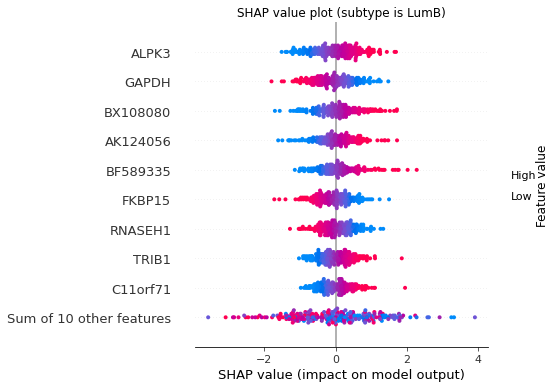

subgroup:  Her2



1it [00:00, 117.63it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
SVC,0.98,0.416667,0.980392,0.0


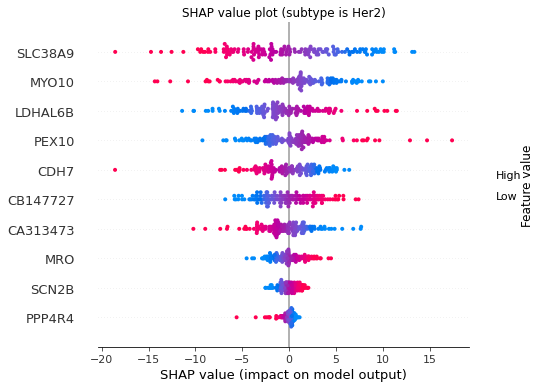

subgroup:  LumA



1it [00:00, 55.41it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
SVC,0.658879,0.636364,0.672646,0.666667


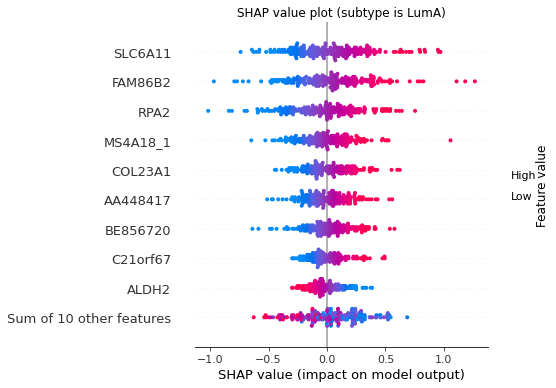

1it [00:01,  1.17s/it]

subgroup:  claudin-low
pkl file does not exist
train data does not exist
subgroup:  Basal
pkl file does not exist
train data does not exist
subgroup:  Normal
pkl file does not exist
train data does not exist
subgroup:  NC
pkl file does not exist
train data does not exist


In [27]:
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = [
    # "none",
    "smote"
]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )

    print(preprocess_order)
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("#####" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            clf = SVC()
            print("subgroup: ", subgroup)

            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
                subgroup_column,
                preprocess_order,
            )
            input_file_name = subgroup
            try:
                _, _, list_train_val, list_test = functions.read_preprocessed_df(
                    input_file_path, input_file_name
                )
            except:
                print("train data does not exist")
                continue

            X_train, y_train = list_train_val[0], list_train_val[1]
            X_test, y_test = list_test[0], list_test[1]

            tuning_file_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_TUNING_RECURRENCE_CROSS_DIR,
                subgroup_column,
                preprocess_order,
                clf.__class__.__name__,
            )
            tuning_file_name_params = "/params_{0}.pkl".format(subgroup)
            best_params = functions.pickle_load(
                tuning_file_path + tuning_file_name_params
            )
            params = {
                "C": best_params["C"],
                "kernel": "linear",
                "max_iter": 10000,
                "class_weight": "balanced",
                "random_state": SEED,
            }
            display(
                functions.compare_bcms(
                    X_train,
                    y_train,
                    X_test,
                    y_test,
                    classifier_names=[clf.__class__.__name__],
                    classifiers=[clf.set_params(**params)],
                    # plot=True,
                )
            )

            clf.set_params(**params)
            clf.fit(X_train, y_train)

            # load JS visualization code to notebook
            shap.initjs()
            # Create object that can calculate shap values
            explainer = shap.Explainer(clf, X_train, feature_names=X_train.columns)
            shap_values = explainer(X_train)
            shap.plots.beeswarm(explainer(X_train), show=False)

            # save fig
            save_fig_path = "{0}/{1}".format(
                config.FIGURES_EXPLAIN_RECURRENCE_CROSS_DIR,
                preprocess_order,
            )
            save_fig_name = "/beeswarm_{0}.png".format(subgroup)
            functions.make_dir(save_fig_path)
            plt.title("SHAP value plot (subtype is {0})".format(subgroup))
            plt.tight_layout()
            plt.savefig(save_fig_path + save_fig_name)
            plt.show()

In [ ]:
params = dict_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lgb"]
params["class_weight"] = "balanced"
params["random_state"] = SEED


lgb = show_test_scores(
    LGBMClassifier(),
    params,
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    "mrmr",
    15,
)
print("-----" * 10)
lgb_sm = show_test_scores(
    LGBMClassifier(),
    params,
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    "mrmr",
    15,
    "sm",
)

# load JS visualization code to notebook
shap.initjs()
# Create object that can calculate shap values
lgb_explainer = shap.TreeExplainer(
    lgb_sm, X_train_global, feature_names=X_train_global.columns
)
lgb_shap_values = lgb_explainer(X_train_global)

In [ ]:
print(y_test_global.iloc[0:10])

# shap value of 'ind' sample
ind = 0
shap.force_plot(
    lgb_explainer.expected_value,
    lgb_shap_values.values[ind],
    X_test_global.iloc[ind],
)

In [ ]:
shap.force_plot(lgb_explainer.expected_value, lgb_shap_values.values, X_train_global)

In [ ]:
shap.summary_plot(lgb_shap_values, X_train_global, show=False)
plt.tight_layout()
plt.savefig(config.SET_NAME_MICROARRAY[INDEX_MICROARRAY] + "_summary.png")

In [ ]:
shap.summary_plot(lgb_shap_values.values, X_train_global, show=False, plot_type="bar")
plt.tight_layout()
plt.savefig(config.SET_NAME_MICROARRAY[INDEX_MICROARRAY] + "_summary_bar.png")

In [ ]:
shap.dependence_plot("S100P", lgb_shap_values.values, X_train_global)

In [ ]:
lgb_shap_interaction_values = shap.TreeExplainer(lgb_sm).shap_interaction_values(
    X_train_global
)

shap.summary_plot(lgb_shap_interaction_values, X_train_global, show=False)
plt.savefig(config.SET_NAME_MICROARRAY[INDEX_MICROARRAY] + "_summary_interaction.png")

In [ ]:
pair = ["RNASE9", "STAT5B"]
shap.dependence_plot(pair, lgb_shap_interaction_values, X_train_global, show=False)
plt.savefig(
    "{0}_dependence_{1}-{2}.png".format(
        config.SET_NAME_MICROARRAY[INDEX_MICROARRAY], pair[0], pair[1]
    )
)

In [ ]:
pair = ["RNASE9", "ENC1"]
shap.dependence_plot(pair, lgb_shap_interaction_values, X_train_global, show=False)
plt.savefig(
    "{0}_dependence_{1}-{2}.png".format(
        config.SET_NAME_MICROARRAY[INDEX_MICROARRAY], pair[0], pair[1]
    )
)

In [ ]:
X_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle")
y_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle")


subtype_optim_params_path = (
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR
    + "/microarray_subtype_optim_params.pickle"
)
dict_subtype_optim_params = (
    pickle_load(subtype_optim_params_path)
    if os.path.exists(subtype_optim_params_path)
    else {}
)


def show_subtype_test_scores(
    clf: callable,
    clf_params: dict(),
    microarray_type: str,
    cat_name: str,
    method: str,
    scaling: str = None,
    is_save: bool = False,
    plot_cfmatrix: bool = False,
):
    subtypes = [
        "claudin-low",
        "LumA",
        "LumB",
        "Her2",
        "Normal",
        "Basal",
    ]

    dict_clf = dict()  # list including trained models
    for subtype in subtypes:
        print("==========" * 10)
        print(subtype)
        prognosis_Xlabel = "X{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
        prognosis_ylabel = "y{0}_{1}".format(config.THRESHOLD_YEAR, subtype)

        X_train = X_dict[microarray_type][cat_name][method]["train"][prognosis_Xlabel]
        y_train = y_dict[microarray_type][cat_name][method]["train"][prognosis_ylabel]
        X_val = X_dict[microarray_type][cat_name][method]["val"][prognosis_Xlabel]
        y_val = y_dict[microarray_type][cat_name][method]["val"][prognosis_ylabel]
        X_test = X_dict[microarray_type][cat_name][method]["test"][prognosis_Xlabel]
        y_test = y_dict[microarray_type][cat_name][method]["test"][prognosis_ylabel]
        print("trainサンプルサイズ：", X_train.shape)
        print("valサンプルサイズ：", X_val.shape)
        print("testサンプルサイズ：", X_test.shape)
        display("ラベル比率(train)：", y_train.value_counts())
        display("ラベル比率(val)：", y_val.value_counts())
        display("ラベル比率(test)：", y_test.value_counts())
        X_train = pd.concat([X_train, X_val])
        y_train = pd.concat([y_train, y_val])

        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
        assert X_val.shape[0] == y_val.shape[0], "val size is incorrect"
        assert X_test.shape[0] == y_test.shape[0], "test size is incorrect"
        assert X_train.shape[1] == X_test.shape[1], "feature size is incorrect"

        # accuracyの表示
        print(
            "train acc baseline[0]: ",
            (y_train == 0).sum() / len(y_train),
        )
        print(
            "train acc baseline[1]: ",
            (y_train == 1).sum() / len(y_train),
        )
        print("test acc baseline[0]: ", (y_test == 0).sum() / len(y_test))
        print("test acc baseline[1]: ", (y_test == 1).sum() / len(y_test))
        # over sampling
        if scaling == "sm":
            sm = SMOTE(random_state=SEED)
            X_train, y_train = sm.fit_resample(X_train, y_train)

        # ML model params setting
        # tmp comment out
        # params = clf_params[subtype][config.THRESHOLD_YEAR]

        params["random_state"] = SEED
        clf.set_params(**params)
        clf.fit(X_train, y_train)  # train
        dict_clf[subtype] = clf
        y_pred_subtype = clf.predict(X_test)  # prediction

        if is_save:
            dir_path = "{0}/prediction_results/{1}/{2}/{3}/{4}".format(
                config.TABLES_EXPLAIN_PROGNOSIS_CROSS_DIR,
                microarray_type,
                cat_name,
                method,
                config.THRESHOLD_YEAR,
            )
            make_dir(dir_path)
            file_name = "/{0}.csv".format(prognosis_Xlabel)
            show_scores(y_test, y_pred_subtype, dir_path + file_name)
        else:
            show_scores(y_test, y_pred_subtype)
        if plot_cfmatrix:
            plot_confusion_matrix(y_test, y_pred_subtype)
    return dict_clf

## Random Forest

In [ ]:
print("---RF---" * 10)
# params = dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["rf"]
params = {"min_samples_split": 20, "min_samples_leaf": 15}
show_subtype_test_scores(
    RandomForestClassifier(),
    params,
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    "mrmr",
    15,
    is_save=True,
    plot_cfmatrix=True,
)

## Logistic Regression

In [ ]:
print("---LR---" * 10)
params = dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lr"]

show_subtype_test_scores(
    LogisticRegression(),
    params,
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    "mrmr",
    15,
)

## LightGBM

In [ ]:
print("---LGB---" * 10)
params = dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lgb"]

lgb_models = show_subtype_test_scores(
    LGBMClassifier(),
    params,
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    "mrmr",
    15,
    is_save=True,
)

## SHAP for subtypes

In [ ]:
dict_subtype_optim_params = pickle_load(
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR
    + "/microarray_subtype_optim_params.pickle"
)


def get_subtype_TreeExplainer_shap_values(
    clf: callable,
    clf_params: dict(),
    microarray_type: str,
    cat_name: str,
    method: str,
    save_figures: bool = False,
):
    subtypes = [
        "claudin-low",
        "LumA",
        "LumB",
        "Her2",
        "Normal",
        "Basal",
    ]

    dict_shap_values = dict()
    dict_shap_interaction_values = dict()

    for subtype in tqdm(subtypes):
        print("==========" * 10)
        print(subtype)
        prognosis_Xlabel = "X{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
        prognosis_ylabel = "y{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
        X_train = X_dict[microarray_type][cat_name][method]["train"][prognosis_Xlabel]
        y_train = y_dict[microarray_type][cat_name][method]["train"][prognosis_ylabel]
        X_val = X_dict[microarray_type][cat_name][method]["val"][prognosis_Xlabel]
        y_val = y_dict[microarray_type][cat_name][method]["val"][prognosis_ylabel]
        X_test = X_dict[microarray_type][cat_name][method]["test"][prognosis_Xlabel]
        y_test = y_dict[microarray_type][cat_name][method]["test"][prognosis_ylabel]
        X_train = pd.concat([X_train, X_val])
        y_train = pd.concat([y_train, y_val])

        print("train size: ", X_train.shape)
        print("test size: ", X_test.shape)
        display("train counts: ", y_train.value_counts())
        display("test counts: ", y_test.value_counts())

        # ML model params setting
        # params = clf_params[subtype][config.THRESHOLD_YEAR]
        params["random_state"] = SEED
        clf.set_params(**params)
        clf.fit(X_train, y_train)  # train
        y_pred_subtype = clf.predict(X_test)  # prediction
        show_scores(y_test, y_pred_subtype)

        # shap
        # summary plot
        shap.initjs()
        shap_values = shap.TreeExplainer(
            clf, X_train, feature_names=X_train.columns
        ).shap_values(X_train)
        if clf.__class__.__name__ == "RandomForestClassifier":
            shap_values = shap_values[1]
        dict_shap_values[subtype] = shap_values
        plt.tight_layout
        shap.summary_plot(shap_values, X_train, show=not save_figures)
        if save_figures:
            dir_path = "{0}/shap_summary_plot/{1}/{2}/{3}/{4/{5}".format(
                config.FIGURES_EXPLAIN_PROGNOSIS_CROSS_DIR,
                clf.__class__.__name__,
                microarray_type,
                cat_name,
                method,
                config.THRESHOLD_YEAR,
            )
            file_name = "/{0}.png".format(subtype)
            make_dir(dir_path)
            plt.savefig(dir_path + file_name)
        plt.clf()

        # interection plot
        shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(
            X_train
        )
        if clf.__class__.__name__ == "RandomForestClassifier":
            shap_interaction_values = shap_interaction_values[1]
        dict_shap_interaction_values[subtype] = shap_interaction_values
        plt.tight_layout
        shap.summary_plot(shap_interaction_values, X_train, show=not save_figures)
        if save_figures:
            dir_path = "{0}/shap_interaction_summary_plot/{1}/{2}/{3}/{4}/{5}".format(
                config.FIGURES_EXPLAIN_PROGNOSIS_CROSS_DIR,
                clf.__class__.__name__,
                microarray_type,
                cat_name,
                method,
                config.THRESHOLD_YEAR,
            )
            file_name = "/{0}.png".format(subtype)
            make_dir(dir_path)
            plt.savefig(dir_path + file_name)
        plt.clf()
    return dict_shap_values, dict_shap_interaction_values

## RandomForest

In [ ]:
# params = dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["rf"]
params = {"min_samples_split": 20, "min_samples_leaf": 15}

dict_shap_values, dict_shap_interaction_values = get_subtype_TreeExplainer_shap_values(
    RandomForestClassifier(),
    params,
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    "mrmr",
    15,
    save_figures=True,
)

In [ ]:
subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Her2",
    "Normal",
    "Basal",
]

X_train_tmp = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["claudin_subtype"][
    "mrmr"
]["train"]["X15_Normal"]
X_val_tmp = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["claudin_subtype"][
    "mrmr"
]["val"]["X15_Normal"]

X_tmp = pd.concat([X_train_tmp, X_val_tmp])

pair = ["ENO4", "SPTAN1"]
shap.dependence_plot(pair, dict_shap_interaction_values["Normal"], X_tmp, show=False)
plt.savefig("{0}_{1}.png".format(pair[0], pair[1]))

In [ ]:
subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Her2",
    "Normal",
    "Basal",
]

X_train_tmp = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["claudin_subtype"][
    "mrmr"
]["train"]["X15_Her2"]
X_val_tmp = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["claudin_subtype"][
    "mrmr"
]["val"]["X15_Her2"]

X_tmp = pd.concat([X_train_tmp, X_val_tmp])

pair = ["PPIE_1", "KRTAP21-1"]
shap.dependence_plot(pair, dict_shap_interaction_values["Her2"], X_tmp, show=False)
plt.savefig("{0}_{1}.png".format(pair[0], pair[1]))

In [ ]:
subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Her2",
    "Normal",
    "Basal",
]

X_train_tmp = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["claudin_subtype"][
    "mrmr"
]["train"]["X15_Her2"]
X_val_tmp = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["claudin_subtype"][
    "mrmr"
]["val"]["X15_Her2"]

X_tmp = pd.concat([X_train_tmp, X_val_tmp])


pair = ["OR4A16", "DOK5"]
shap.dependence_plot(pair, dict_shap_interaction_values["Her2"], X_tmp)

## LGB

In [ ]:
params = dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lgb"]


dict_shap_values, dict_shap_interaction_values = get_subtype_TreeExplainer_shap_values(
    LGBMClassifier(),
    params,
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    "mrmr",
    15,
    save_figures=True,
)

In [ ]:
subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Her2",
    "Normal",
    "Basal",
]

X_train_tmp = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["claudin_subtype"][
    "mrmr"
]["train"]["X15_Her2"]
X_val_tmp = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["claudin_subtype"][
    "mrmr"
]["val"]["X15_Her2"]

X_tmp = pd.concat([X_train_tmp, X_val_tmp])


pair = ["MAP6D1", "OR4A16"]
shap.dependence_plot(pair, dict_shap_interaction_values["Her2"], X_tmp, show=False)
plt.savefig("{0}_{1}.png".format(pair[0], pair[1]))

In [ ]:
subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Her2",
    "Normal",
    "Basal",
]

X_train_tmp = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["claudin_subtype"][
    "mrmr"
]["train"]["X15_Her2"]
X_val_tmp = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["claudin_subtype"][
    "mrmr"
]["val"]["X15_Her2"]

X_tmp = pd.concat([X_train_tmp, X_val_tmp])


pair = ["OR4A16", "DOK5"]
shap.dependence_plot(pair, dict_shap_interaction_values["Her2"], X_tmp)

In [ ]:
X_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle")
y_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle")


def do_compare_bcms(
    microarray_type: str,
    cat_name: str,
    method: str,
    sampling: str = None,
):
    thresholds_list = [[0, 50], [50, 100]]

    for thresholds in thresholds_list:
        prognosis_Xlabel = "X{0}_{1}to{2}".format(
            config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
        )
        prognosis_ylabel = "y{0}_{1}to{2}".format(
            config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
        )

        X_train = X_dict[microarray_type][cat_name][method]["train"][prognosis_Xlabel]
        y_train = y_dict[microarray_type][cat_name][method]["train"][prognosis_ylabel]
        X_val = X_dict[microarray_type][cat_name][method]["val"][prognosis_Xlabel]
        y_val = y_dict[microarray_type][cat_name][method]["val"][prognosis_ylabel]
        X_test = X_dict[microarray_type][cat_name][method]["test"][prognosis_Xlabel]
        y_test = y_dict[microarray_type][cat_name][method]["test"][prognosis_ylabel]
        if X_train.shape[0] + X_val.shape[0] < 50:
            continue
        print("----------" * 10)
        print("trainサンプルサイズ：", X_train.shape)
        print("valサンプルサイズ：", X_val.shape)
        print("testサンプルサイズ：", X_test.shape)
        display("ラベル比率(train)：", y_train.value_counts())
        display("ラベル比率(val)：", y_val.value_counts())
        display("ラベル比率(test)：", y_test.value_counts())
        X_train_val = pd.concat([X_train, X_val])
        y_train_val = pd.concat([y_train, y_val])

        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
        assert X_val.shape[0] == y_val.shape[0], "val size is incorrect"
        assert X_test.shape[0] == y_test.shape[0], "test size is incorrect"
        assert X_train_val.shape[1] == X_test.shape[1], "feature size is incorrect"

        # accuracyの表示
        print("age span: ", thresholds)
        print(
            "train acc baseline[0]: ",
            (y_train_val == 0).sum() / len(y_train_val),
        )
        print(
            "train acc baseline[1]: ",
            (y_train_val == 1).sum() / len(y_train_val),
        )
        print(
            "test acc baseline[0]: ",
            (y_test == 0).sum() / len(y_test),
        )
        print(
            "test acc baseline[1]: ",
            (y_test == 1).sum() / len(y_test),
        )
        # over sampling
        if sampling == "sm":
            sm = SMOTE(random_state=SEED)
            X_train_val, y_train_val = sm.fit_resample(X_train_val, y_train_val)

        display(compare_bcms(X_train, y_train, X_test, y_test))


do_compare_bcms(config.SET_NAME_MICROARRAY[INDEX_MICROARRAY], "age", "mrmr")

## each models

## prediction

In [ ]:
X_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle")
y_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle")

microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "age"
method = "mrmr"
optim_params_path = (
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR
    + "/{0}/{1}/{2}/optim_params.pickle".format(microarray_type, cat_name, method)
)

dict_optim_params = (
    pickle_load(optim_params_path) if os.path.exists(optim_params_path) else {}
)


def show_test_scores_age(
    microarray_type: str,
    cat_name: str,
    method: str,
    clf: callable,
    clf_params: dict() = None,
    sampling: str = None,
    is_save: bool = False,
    plot_cfmatrix: bool = False,
):

    thresholds_list = [[0, 50], [50, 100]]

    dict_clf = dict()  # list including trained models

    for thresholds in thresholds_list:
        print("thresholds: ", thresholds)
        prognosis_Xlabel = "X{0}_{1}to{2}".format(
            config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
        )
        prognosis_ylabel = "y{0}_{1}to{2}".format(
            config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
        )

        X_train = X_dict[microarray_type][cat_name][method]["train"][prognosis_Xlabel]
        y_train = y_dict[microarray_type][cat_name][method]["train"][prognosis_ylabel]
        X_val = X_dict[microarray_type][cat_name][method]["val"][prognosis_Xlabel]
        y_val = y_dict[microarray_type][cat_name][method]["val"][prognosis_ylabel]
        X_test = X_dict[microarray_type][cat_name][method]["test"][prognosis_Xlabel]
        y_test = y_dict[microarray_type][cat_name][method]["test"][prognosis_ylabel]
        if X_train.shape[0] + X_val.shape[0] < 50:
            continue
        print("----------" * 10)
        print("trainサンプルサイズ：", X_train.shape)
        print("valサンプルサイズ：", X_val.shape)
        print("testサンプルサイズ：", X_test.shape)
        display("ラベル比率(train)：", y_train.value_counts())
        display("ラベル比率(val)：", y_val.value_counts())
        display("ラベル比率(test)：", y_test.value_counts())
        X_train_val = pd.concat([X_train, X_val])
        y_train_val = pd.concat([y_train, y_val])

        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
        assert X_val.shape[0] == y_val.shape[0], "val size is incorrect"
        assert X_test.shape[0] == y_test.shape[0], "test size is incorrect"
        assert X_train_val.shape[1] == X_test.shape[1], "feature size is incorrect"

        # accuracyの表示
        print("age span: ", thresholds)
        print(
            "train acc baseline[0]: ",
            (y_train_val == 0).sum() / len(y_train_val),
        )
        print(
            "train acc baseline[1]: ",
            (y_train_val == 1).sum() / len(y_train_val),
        )
        print(
            "test acc baseline[0]: ",
            (y_test == 0).sum() / len(y_test),
        )
        print(
            "test acc baseline[1]: ",
            (y_test == 1).sum() / len(y_test),
        )
        # over sampling
        if sampling == "sm":
            sm = SMOTE(random_state=SEED)
            X_train_val, y_train_val = sm.fit_resample(X_train_val, y_train_val)

        # ML model params setting
        # tmp comment out
        # params = clf_params[subtype][config.THRESHOLD_YEAR]

        if clf_params:
            params = clf_params[prognosis_Xlabel]
            params["random_state"] = SEED
            clf.set_params(**clf_params[prognosis_Xlabel])
        clf.fit(X_train_val, y_train_val)  # train
        dict_clf[prognosis_Xlabel] = clf
        y_pred = clf.predict(X_test)  # prediction

        if is_save:
            dir_path = "{0}/prediction_results/{1}/{2}/{3}/{4}".format(
                config.TABLES_EXPLAIN_PROGNOSIS_CROSS_DIR,
                microarray_type,
                cat_name,
                method,
                config.THRESHOLD_YEAR,
            )
            make_dir(dir_path)
            file_name = "/{0}.csv".format(prognosis_Xlabel)
            show_scores(y_test, y_pred, dir_path + file_name)
        else:
            show_scores(y_test, y_pred)
        if plot_cfmatrix:
            plot_confusion_matrix(y_test, y_pred)
    return dict_clf

### Random Forest

In [ ]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "age"
method = "mrmr"

clf = RandomForestClassifier()

show_test_scores_age(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
    clf=clf,
    # clf_params=dict_optim_params["rf"],
    plot_cfmatrix=True,
)

In [ ]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "age"
method = "mrmr"

clf = RandomForestClassifier()

dict_clf = show_test_scores_age(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
    clf=clf,
    clf_params=dict_optim_params["rf"],
    plot_cfmatrix=True,
)

### SHAP

In [ ]:
def get_TreeExplainer_shap_values(
    microarray_type: str,
    cat_name: str,
    method: str,
    clf: callable,
    clf_params: dict() = None,
    # dict_clf: callable,
    save_figures: bool = False,
):

    dict_shap_values = dict()
    dict_shap_interaction_values = dict()

    for thresholds in thresholds_list:
        print("thresholds: ", thresholds)
        prognosis_Xlabel = "X{0}_{1}to{2}".format(
            config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
        )
        prognosis_ylabel = "y{0}_{1}to{2}".format(
            config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
        )

        X_train = X_dict[microarray_type][cat_name][method]["train"][prognosis_Xlabel]
        y_train = y_dict[microarray_type][cat_name][method]["train"][prognosis_ylabel]
        X_val = X_dict[microarray_type][cat_name][method]["val"][prognosis_Xlabel]
        y_val = y_dict[microarray_type][cat_name][method]["val"][prognosis_ylabel]
        X_test = X_dict[microarray_type][cat_name][method]["test"][prognosis_Xlabel]
        y_test = y_dict[microarray_type][cat_name][method]["test"][prognosis_ylabel]
        if X_train.shape[0] + X_val.shape[0] < 50:
            continue
        print("----------" * 10)
        print("trainサンプルサイズ：", X_train.shape)
        print("valサンプルサイズ：", X_val.shape)
        print("testサンプルサイズ：", X_test.shape)
        display("ラベル比率(train)：", y_train.value_counts())
        display("ラベル比率(val)：", y_val.value_counts())
        display("ラベル比率(test)：", y_test.value_counts())
        X_train_val = pd.concat([X_train, X_val])
        y_train_val = pd.concat([y_train, y_val])

        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
        assert X_val.shape[0] == y_val.shape[0], "val size is incorrect"
        assert X_test.shape[0] == y_test.shape[0], "test size is incorrect"
        assert X_train_val.shape[1] == X_test.shape[1], "feature size is incorrect"

        # model train
        if clf_params:
            params = clf_params[prognosis_Xlabel]
            params["random_state"] = SEED
            clf.set_params(**clf_params[prognosis_Xlabel])
        clf.fit(X_train_val, y_train_val)  # train

        # shap
        # summary plot
        shap.initjs()
        shap_values = shap.TreeExplainer(
            clf, X_train_val, feature_names=X_train_val.columns
        ).shap_values(X_train_val)
        if clf.__class__.__name__ == "RandomForestClassifier":
            shap_values = shap_values[1]
        dict_shap_values[prognosis_Xlabel] = shap_values
        plt.tight_layout
        shap.summary_plot(shap_values, X_train_val, show=not save_figures)
        if save_figures:
            dir_path = "{0}/shap_summary_plot/{1}/{2}/{3}/{4}".format(
                config.FIGURES_EXPLAIN_PROGNOSIS_CROSS_DIR,
                microarray_type,
                cat_name,
                method,
                clf.__class__.__name__,
            )
            file_name = "/{0}.png".format(prognosis_Xlabel)
            make_dir(dir_path)
            plt.savefig(dir_path + file_name)
        plt.clf()

        # interection plot
        shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(
            X_train_val
        )
        if clf.__class__.__name__ == "RandomForestClassifier":
            shap_interaction_values = shap_interaction_values[1]
        dict_shap_interaction_values[prognosis_Xlabel] = shap_interaction_values
        plt.tight_layout
        shap.summary_plot(shap_interaction_values, X_train_val, show=not save_figures)
        if save_figures:
            dir_path = "{0}/shap_interaction_summary_plot/{1}/{2}/{3}/{4}".format(
                config.FIGURES_EXPLAIN_PROGNOSIS_CROSS_DIR,
                microarray_type,
                cat_name,
                method,
                clf.__class__.__name__,
            )
            file_name = "/{0}.png".format(prognosis_Xlabel)
            make_dir(dir_path)
            plt.savefig(dir_path + file_name)
        plt.clf()
    return dict_shap_values, dict_shap_interaction_values

In [ ]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "age"
method = "mrmr"

clf = RandomForestClassifier()

dict_shap_values, dict_shap_interaction_values = get_TreeExplainer_shap_values(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
    clf=clf,
    clf_params=dict_optim_params["rf"],
)

In [ ]:
thresholds_list = [[0, 50], [50, 100]]
thresholds = thresholds_list[0]
dict_clf = dict()  # list including trained models

prognosis_Xlabel = "X{0}_{1}to{2}".format(
    config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
)
prognosis_ylabel = "y{0}_{1}to{2}".format(
    config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
)

X_train_tmp = X_dict[microarray_type][cat_name][method]["train"][prognosis_Xlabel]
X_val_tmp = X_dict[microarray_type][cat_name][method]["val"][prognosis_Xlabel]

X_train_val_tmp = pd.concat([X_train_tmp, X_val_tmp])

pair = ["SLC52A2", "SEC61A2"]
shap.dependence_plot(
    pair,
    dict_shap_interaction_values[prognosis_Xlabel],
    X_train_val_tmp,
    show=False,
)
# plt.savefig("{0}_{1}.png".format(pair[0], pair[1]))

### SVC

In [ ]:
dict_optim_params = (
    pickle_load(optim_params_path) if os.path.exists(optim_params_path) else {}
)

microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "age"
method = "mrmr"

clf = SVC()

dict_clf = show_test_scores_age(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
    clf=clf,
    clf_params=dict_optim_params["svc"],
    plot_cfmatrix=True,
)

### Logistic Regression

In [ ]:
dict_optim_params = (
    pickle_load(optim_params_path) if os.path.exists(optim_params_path) else {}
)

microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "age"
method = "mrmr"

clf = LogisticRegression()

dict_clf = show_test_scores_age(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
    clf=clf,
    clf_params=dict_optim_params["lr"],
    plot_cfmatrix=True,
)

### LogisticRegression

In [ ]:
print("---LGB---" * 10)

lr_models = show_test_scores_subtype_and_age(
    clf=LogisticRegression(),
    microarray_type=config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    cat_name="subtype_and_age",
    method="mrmr",
    clf_params={"random_state": SEED},
    is_save=True,
)

### decision Tree

In [ ]:
dt_models = show_test_scores_subtype_and_age(
    clf=DecisionTreeClassifier(),
    microarray_type=config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    cat_name="subtype_and_age",
    method="mrmr",
    clf_params={
        "min_samples_split": 20,
        "min_samples_leaf": 15,
        "random_state": SEED,
        "class_weight": "balanced",
    },
    is_save=True,
)

### SVM

In [ ]:
print("---SVM---" * 10)

svm_models = show_test_scores_subtype_and_age(
    clf=SVC(kernel="poly", random_state=SEED),
    microarray_type=config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    cat_name="subtype_and_age",
    method="mrmr",
    clf_params={"C": 10000},
    scaling="sm",
    is_save=True,
)

### lightGBM

In [ ]:
print("---LGB---" * 10)

lgb_models = show_test_scores_subtype_and_age(
    clf=LGBMClassifier(),
    microarray_type=config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    cat_name="subtype_and_age",
    method="mrmr",
    scaling="sm",
    is_save=True,
)